# Brewster's Angle

In [1]:
from poke.poke_math import np
from poke.polarization import brewsters_angle
n1 = 1.
n2 = 1.516800 # nbk7 at 600nm
print(np.degrees(brewsters_angle(n1, n2)))


56.603826176326386


In [2]:
from poke.poke_core import Rayfront
from poke.poke_math import np

pth_to_lens = 'C:/Users/Work/Desktop/poke/experiments/physics_validation/brewster.len'

# rayfront parameters
number_of_rays = 20 # across the entrance pupil
wavelength = 0.6e-6
pupil_radius = 50 # semi-aperture of Hubble
max_field_of_view = 1 # degrees
nbk7 =  1.516800
glass = {"surf": 2, "coating": nbk7, "mode": "reflect"}

rf_cv = Rayfront(number_of_rays, wavelength, pupil_radius, max_field_of_view, circle=False)
rf_cv.as_polarized([glass])

norm fov =  [0. 0.]
base ray shape  (4, 400)


C:\Users\Work\Desktop\poke\poke\raytrace.py:67: SyntaxWarning: invalid escape sequence '\R'
  dll = os.path.dirname(__file__) + "\RayTrace.dll"


In [3]:
rf_cv.trace_rayset(pth_to_lens)
rf_cv.compute_jones_pupil(aloc=np.array([0., 1., 0.]))

CODE V warning: Warning: Default recover file in use - writing to codev57832.rec 
res C:/Users/Work/Desktop/poke/experiments/physics_validation/brewster.len
CODE V warning: Warning: Buffer number 0 does not exist.  Nothing deleted. 
global coordinate reference set to surface 1
maxrays =  400
CODE V warning: Warning: Buffer number 1 does not exist.  Nothing deleted. 
1 Raysets traced through 1 surfaces


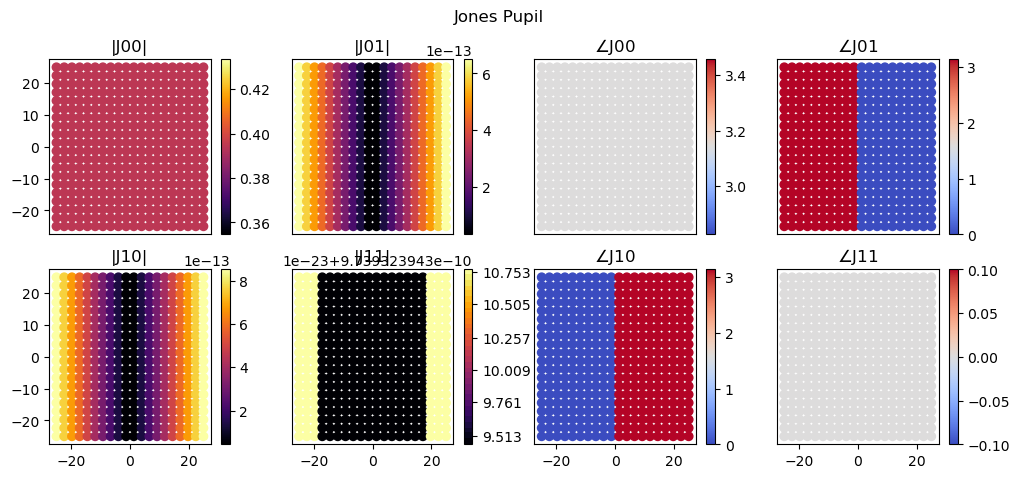

In [4]:
import poke.plotting as plot
plot.jones_pupil(rf_cv)

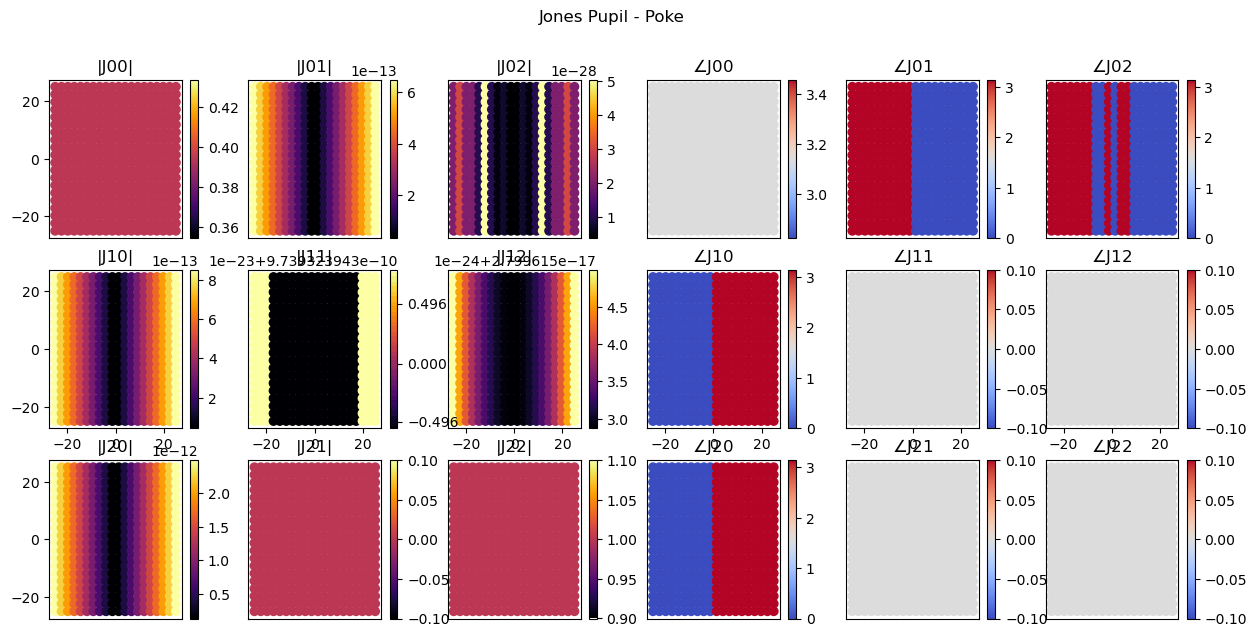

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=[15, 7], nrows=3, ncols=6)
plt.suptitle("Jones Pupil - Poke")
for j in range(3):
    for k in range(3):
        ax = axs[j, k]
        ax.set_title("|J{j}{k}|".format(j=j, k=k))
        sca = ax.scatter(rf_cv.xData[0,0], rf_cv.yData[0,0], c=np.abs(rf_cv.jones_pupil[-1][...,j, k]), cmap="inferno")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)
        if k != 0:
            ax.yaxis.set_visible(False)

# theres a phase offset
offset = 0

for j in range(3):
    for k in range(3):

        if k == 1:
            if j == 0:
                offset = np.pi
        else:
            offset = 0
        ax = axs[j, k + 3]
        ax.set_title(r"$\angle$" + "J{j}{k}".format(j=j, k=k))
        sca = ax.scatter(rf_cv.xData[0,0], rf_cv.yData[0,0], c=np.angle(rf_cv.jones_pupil[-1][...,j, k]), cmap="coolwarm")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks 
        if j != 1:
            ax.xaxis.set_visible(False)

        ax.yaxis.set_visible(False)
plt.show()

# Same System in Transmission

In [6]:
pth_to_lens = 'C:/Users/Work/Desktop/poke/experiments/physics_validation/brewster_transmission.len'

front = {"surf": 2, "coating": (1., nbk7), "mode": "transmit"}
rear = {"surf": 3, "coating": (nbk7, 1.), "mode": "transmit"}

rf_cv = Rayfront(number_of_rays, wavelength, pupil_radius, max_field_of_view, circle=False)
rf_cv.as_polarized([front, rear])
rf_cv.trace_rayset(pth_to_lens)
rf_cv.compute_jones_pupil()

norm fov =  [0. 0.]
base ray shape  (4, 400)
CODE V warning: Warning: Default recover file in use - writing to codev56264.rec 
res C:/Users/Work/Desktop/poke/experiments/physics_validation/brewster_transmission.len
CODE V warning: Warning: Buffer number 0 does not exist.  Nothing deleted. 
global coordinate reference set to surface 1
maxrays =  400
CODE V warning: Warning: Buffer number 1 does not exist.  Nothing deleted. 
1 Raysets traced through 2 surfaces


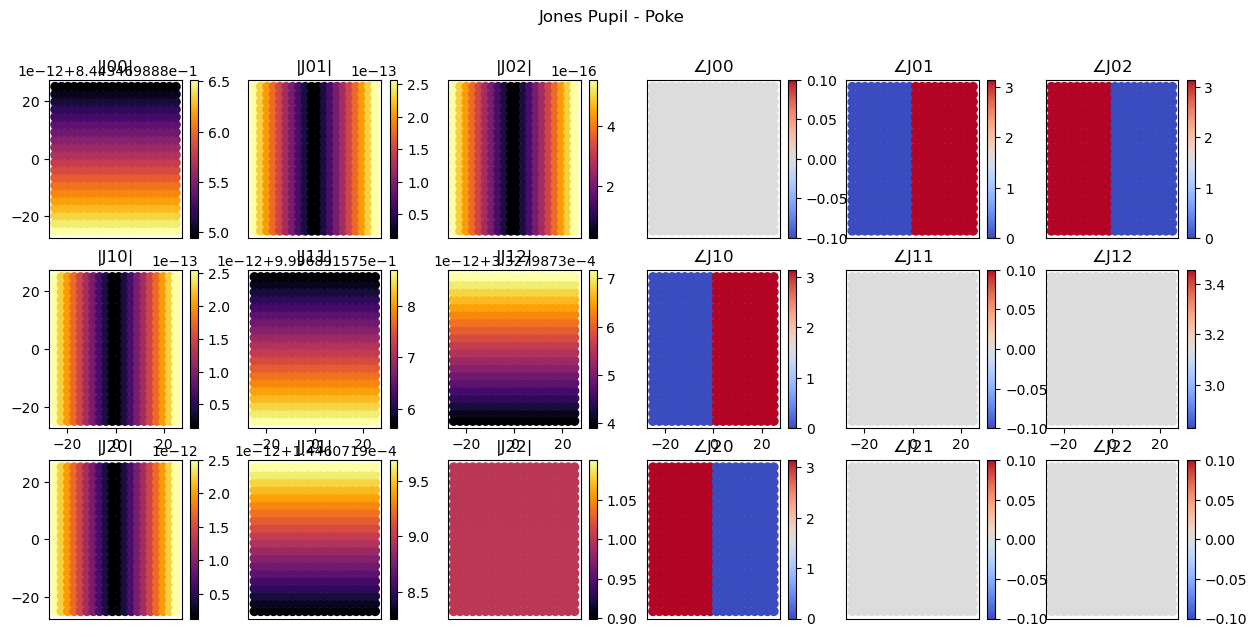

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=[15, 7], nrows=3, ncols=6)
plt.suptitle("Jones Pupil - Poke")
for j in range(3):
    for k in range(3):
        ax = axs[j, k]
        ax.set_title("|J{j}{k}|".format(j=j, k=k))
        sca = ax.scatter(rf_cv.xData[0,0], rf_cv.yData[0,0], c=np.abs(rf_cv.jones_pupil[-1][...,j, k]), cmap="inferno")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks
        if j != 1:
            ax.xaxis.set_visible(False)
        if k != 0:
            ax.yaxis.set_visible(False)

# theres a phase offset
offset = 0

for j in range(3):
    for k in range(3):

        if k == 1:
            if j == 0:
                offset = np.pi
        else:
            offset = 0
        ax = axs[j, k + 3]
        ax.set_title(r"$\angle$" + "J{j}{k}".format(j=j, k=k))
        sca = ax.scatter(rf_cv.xData[0,0], rf_cv.yData[0,0], c=np.angle(rf_cv.jones_pupil[-1][...,j, k]), cmap="coolwarm")
        fig.colorbar(sca, ax=ax)

        # turn off the ticks 
        if j != 1:
            ax.xaxis.set_visible(False)

        ax.yaxis.set_visible(False)
plt.show()

This basically makes sense, the J11 component is near unity, which is what we would expect for a plane parallel plate tilted at brewster's angle. However, we still see these off-diagonals (J02, J20) at a nonzero value. 

I suspect that it's our computation of angle of incidence / refraction. Poke doesn't grab this data directly, we compute it from direction cosines via Snell's law. The following shows the function that does so.

In [12]:
from poke.raytrace import convert_ray_data_to_prt_data

aoi, kin, kout, normal = convert_ray_data_to_prt_data(rf_cv.lData[0], rf_cv.mData[0], rf_cv.nData[0],
                                                      rf_cv.l2Data[0], rf_cv.m2Data[0], rf_cv.n2Data[0],
                                                      rf_cv.surfaces, ambient_index=1)

l2Data, m2Data, n2Data = rf_cv.l2Data[0], rf_cv.m2Data[0], rf_cv.n2Data[0]
lData, mData, nData = rf_cv.lData[0], rf_cv.mData[0], rf_cv.nData[0]

norm = -np.array([l2Data, m2Data, n2Data])

numerator = lData * l2Data + mData * m2Data + nData * n2Data
denominator = np.sqrt(lData ** 2 + mData ** 2 + nData ** 2) * np.sqrt(l2Data ** 2 + m2Data ** 2 + n2Data ** 2)
aoe = np.arccos(-numerator / denominator)  # now in radians

In [13]:
aoi_deg = np.degrees(aoi)
aoe_deg = np.degrees(aoe)

These should be the same, and in CODE V they indeed are. However, the AOI computation from Snell's law is off by a factor of $\approx 10^{-4}$ radians, which is the order of magnitude of the difference that we see in the refractive examples.

In [21]:
print('Angle of Incidence before plate = ', aoi_deg[0,0])
print('Angle of Refraction after plate = ',aoe_deg[-1,0])
print('Difference = ', aoi[0][0] - aoe[-1, 0],' radians')

Angle of Incidence before plate =  56.63276880807865
Angle of Refraction after plate =  56.60383752979632
Difference =  0.0005049460628373525  radians


Also, note that CODE V's direction cosines are multiplied by the refractive index.

In [23]:
dir = np.array([0.00000,    -0.83488,     1.26575])
print(np.linalg.norm(dir))
print(nbk7)

1.5162940601677497
1.5168
